## MLOps 2021

#### How Not to Let Your Model and Data Drift Away Silently

The following notebook is an accompaniment to the MLOps talk, "How Not to Let Your Model and Data Drift Away Silently"

*Notebooks and slides are available here:* [http://bit.ly/mlops2021-drifting-away](https://github.com/chengyin38/mlops_2021_drifting_away)

**Data Citation:**
* *[Inside Airbnb - Hawaii Listings Dataset](http://insideairbnb.com/get-the-data.html)*


**Requirements**
* The following notebook was developed and tested using [DBR 8.2 ML](https://docs.databricks.com/release-notes/runtime/8.2ml.html)
* Additional dependencies:
  * `mlflow==1.16.0`
  * `scipy==1.6.3`
  * `seaborn==0.11.1`
  
**Authors**
- Chengyin Eng
- Niall Turbitt

### Outline

We simulate a batch inference scenario where we train, deploy, and maintain a model to predict Airbnb house listings in Hawaii on a monthly basis. 

**Data interval**: Arrives monthly <br>

**Workflow**: 
<img src="https://i.ibb.co/YjJ9mbb/Screen-Shot-2021-06-12-at-11-04-55-AM.png">
* Load the new month of incoming data
* Apply incoming data checks 
  * Error and drift evaluation
* Identify and address any errors and drifts
* Train a new model
* Apply model validation checks versus the existing model in production
    * If checks pass, deploy the new candidate model to production
    * If checks fail, do not deploy the new candidate model <br>

**Reproducibility Tools**: 
* [MLflow](https://www.mlflow.org/docs/latest/index.html) for model parameters, metrics, and artifacts
* [Delta](https://docs.delta.io/latest/index.html) for data versioning <br>

<img src="https://i.ibb.co/g34XSVm/Screen-Shot-2021-06-12-at-11-10-08-AM.png" alt="Screen-Shot-2021-06-12-at-11-10-08-AM" border="0">

Although this notebook specifically addresses tests to monitor a supervised ML model for batch inference, the same tests are applicable in streaming and real-time settings.

### Run setup and utils notebooks

In [0]:
%run ./training_setup

Python interpreter will be restarted.
Collecting mlflow==1.16.0
 Using cached mlflow-1.16.0-py3-none-any.whl (14.2 MB)
Collecting scipy==1.6.3
 Using cached scipy-1.6.3-cp38-cp38-manylinux1_x86_64.whl (27.2 MB)
Collecting seaborn==0.11.1
 Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
Requirement already satisfied: entrypoints in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (0.3)
Requirement already satisfied: protobuf>=3.6.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (3.13.0)
Requirement already satisfied: numpy in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (1.19.2)
Requirement already satisfied: pandas in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (1.1.5)
Requirement already satisfied: databricks-cli>=0.8.7 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (0.14.3)
Requirement already satisfied: gitpython>=2.1.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (3.1.12)
Processing /root/.cache/pip/wheels/69/6f/b4/2087abb1172ae32c58e366dc09746de46a72b0e9fb2c022920/prometheus_flask_exporter-0.18.2-py3-none-any.whl
Requirement already satisfied: pyyaml in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (5.4.1)
Requirement already satisfied: requests>=2.17.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (2.24.0)
Requirement already satisfied: cloudpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (1.6.0)
Requirement already satisfied: Flask in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (1.1.2)
Collecting sqlalchemy
 Using cached SQLAlchemy-1.4.18-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Requirement already satisfied: sqlparse>=0.3.1 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (0.4.1)
Requirement already satisfied: querystring-parser in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (1.2.4)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (20.0.4)
Processing /root/.cache/pip/wheels/9d/de/6d/ca8d461ec29e010b1267d7353d0b058819770f7680bb9360e4/alembic-1.4.1-py2.py3-none-any.whl
Requirement already satisfied: click>=7.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (7.1.2)
Requirement already satisfied: pytz in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (2020.5)
Requirement already satisfied: docker>=4.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from mlflow==1.16.0) (4.4.4)
Requirement already satisfied: matplotlib>=2.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-41c2-91d5-883c010b8536/lib/python3.8/site-packages (from seaborn==0.11.1) (3.2.2)
Requirement already satisfied: six>=1.9 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-e7249b92-9e04-4

Python interpreter will be restarted.
Collecting mlflow==1.16.0
 Using cached mlflow-1.16.0-py3-none-any.whl (14.2 MB)
Collecting scipy==1.6.3
 Using cached scipy-1.6.3-cp38-cp38-manylinux1_x86_64.whl (27.2 MB)
Collecting seaborn==0.11.1
 Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
Requirement already satisfied: pytz in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (2020.5)
Collecting sqlalchemy
 Using cached SQLAlchemy-1.4.13-cp38-cp38-manylinux2014_x86_64.whl (1.5 MB)
Requirement already satisfied: pandas in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (1.1.3)
Requirement already satisfied: databricks-cli>=0.8.7 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (0.14.3)
Collecting sqlparse>=0.3.1
 Using cached sqlparse-0.4.1-py3-none-any.whl (42 kB)
Processing /root/.cache/pip/wheels/9d/de/6d/ca8d461ec29e010b1267d7353d0b058819770f7680bb9360e4/alembic-1.4.1-py2.py3-none-any.whl
Requirement already satisfied: numpy in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (1.19.2)
Requirement already satisfied: pyyaml in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (5.4.1)
Requirement already satisfied: gunicorn; platform_system != "Windows" in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (20.0.4)
Requirement already satisfied: click>=7.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (7.1.2)
Processing /root/.cache/pip/wheels/69/6f/b4/2087abb1172ae32c58e366dc09746de46a72b0e9fb2c022920/prometheus_flask_exporter-0.18.2-py3-none-any.whl
Requirement already satisfied: docker>=4.0.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (4.4.4)
Requirement already satisfied: cloudpickle in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (1.6.0)
Requirement already satisfied: entrypoints in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (0.3)
Requirement already satisfied: gitpython>=2.1.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (3.1.12)
Requirement already satisfied: querystring-parser in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (1.2.4)
Requirement already satisfied: protobuf>=3.6.0 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (3.13.0)
Requirement already satisfied: requests>=2.17.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (2.24.0)
Requirement already satisfied: Flask in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from mlflow==1.16.0) (1.1.2)
Requirement already satisfied: matplotlib>=2.2 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/python3.8/site-packages (from seaborn==0.11.1) (3.2.2)
Collecting greenlet!=0.4.17; python_version >= "3"
 Using cached greenlet-1.0.0-cp38-cp38-manylinux2010_x86_64.whl (165 kB)
Requirement already satisfied: python-dateutil>=2.7.3 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-79feb994-226e-46f9-ad3b-92c60c4d3d3b/lib/pyth

chengyin.eng@databricks.com

chengyin.eng@databricks.com

Out[3]: True

Out[3]: True

Deleting following registered model: airbnb_hawaii

Deleting following registered model: airbnb_hawaii

In [0]:
%run ./monitoring_utils

In [0]:
dbutils.widgets.removeAll()
dbutils.widgets.text("stats_threshold_limit", "0.5")
dbutils.widgets.text("p_threshold", "0.05")
dbutils.widgets.text("min_model_r2_threshold", "0.005")

stats_threshold_limit = float(dbutils.widgets.get("stats_threshold_limit"))       # how much we should allow basic summary stats to shift 
p_threshold = float(dbutils.widgets.get("p_threshold"))                           # the p-value below which to reject null hypothesis 
min_model_r2_threshold = float(dbutils.widgets.get("min_model_r2_threshold"))     # minimum model improvement

### Month 0

* Train an inital model to predict listing prices and deploy to Production
* As we have no historic data or existing models in production to compare against, we do not apply error and distribution checks here.

#### i. Initial Data load

Load the first month of data which we use to train and evaluate our first model. 

We create a "Gold" table to which we will be appending each subsequent month of data.

In [0]:
# Define the path to use for our Gold table
gold_delta_path = data_project_dir + "airbnb_hawaii_delta"

# Ensure we start with no existing Delta table 
dbutils.fs.rm(gold_delta_path, True)

# Incoming Month 0 Data
month_0_df = spark.read.format("delta").load(month_0_delta_path)

# Create inital version of the Gold Delta table we will use for training - this will be updated with subsequent "months" of data
month_0_df.withColumn("month", F.lit("month_0")).write.format("delta").partitionBy("month").save(gold_delta_path)

In [0]:
display(dbutils.fs.ls("dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/"))

path,name,size
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/.s3-optimization-0,.s3-optimization-0,0
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/.s3-optimization-1,.s3-optimization-1,0
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/.s3-optimization-2,.s3-optimization-2,0
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000000.crc,00000000000000000000.crc,90
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000000.json,00000000000000000000.json,2933
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000001.crc,00000000000000000001.crc,91
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000001.json,00000000000000000001.json,1568
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000002.crc,00000000000000000002.crc,91
dbfs:/Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta/_delta_log/00000000000000000002.json,00000000000000000002.json,1595


#### ii. Model Training

In [0]:
# Set the month number - used for naming the MLflow run and tracked as a parameter 
month = 0

# Specify name of MLflow run
run_name = f"month_{month}"

# Define the parameters to pass in the RandomForestRegressor model
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}

# Define a dictionary of parameters that we would like to use during preprocessing
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}

# Trigger model training and logging to MLflow
month_0_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path, 
                                     model_params, 
                                     misc_params)

#### iii. Model Deployment

We first register the model to the [MLflow Model Registry](https://www.mlflow.org/docs/latest/model-registry.html). For demonstration purposes we will immediately transition the model to the "Production" stage in the MLflow Model Registry, however in a real world scenario one should have a robust model validation process in place prior to migrating a model to Production. 

We will demonstrate a multi-stage approach in the subsequent sections, first transitioning a model to "Staging", conducting model validation checks, and only then triggering a transition from Staging to Production once these checks are satistified.

In [0]:
# Register model to MLflow Model Registry
month_0_run_id = month_0_run.info.run_id
month_0_model_version = mlflow.register_model(model_uri=f"runs:/{month_0_run_id}/model", name=registry_model_name)

Successfully registered model 'airbnb_hawaii'.
2021/06/12 16:46:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: airbnb_hawaii, version 1
Created version '1' of model 'airbnb_hawaii'.

In [0]:
# Transition model to Production
month_0_model_version = transition_model(month_0_model_version, stage="Production")
print(month_0_model_version)

<ModelVersion: creation_timestamp=1623516375635, current_stage='Production', description='', last_updated_timestamp=1623516382237, name='airbnb_hawaii', run_id='4c7288c70f344f479df16df1513f1418', run_link='', source='dbfs:/databricks/mlflow-tracking/2808846569707146/4c7288c70f344f479df16df1513f1418/artifacts/model', status='READY', status_message='', tags={}, user_id='4470711271069202', version='1'>

### Month 1 - New Data Arrives

Our model has been deployed for a month and we now have an incoming fresh month of data.

**Scenario 1:**
* During the upstream data cleansing process, certain neighbourhoods are missing their `neighbourhood_cleansed` entries, i.e. Primary Urban Center, Kihei-Makena, Lahaina, North Kona
* Also during the upstream data generation procedure a new "star" rating system between 0 and 5 for `review_scores_rating` was introduced without our knowledge.
  - Instances in this new month of data will have `review_scores_rating` entries scaled between 0 and 5, where historic entries were bounded between 0 and 100.
  
**What are we simulating here?**
* Feature drift
* Upstream data errors

#### i. Feature checks prior to model training

**All features**
* Null checks

**Numeric features**
* Summary statistic checks: mean, median, standard deviation, minimum, maximum
* Distribution checks

**Categorical features**
* Check expected count for each level
* Check the mode

In [0]:
# Incoming Month 1 Data - we have synthesised some errors/distribution changes in our data that we would necessarily want to catch
# Create pandas DataFrame from Spark DataFrame 
# (note that we are doing this due to the small size of this data, however caution should be taken here for larger datasets)
month_1_err_pdf = spark.read.format("delta").load(month_1_error_delta_path).toPandas()

# Compute summary statistics on new incoming data
summary_stats_month_1_err_pdf = create_summary_stats_pdf(month_1_err_pdf)

In [0]:
# Get the original MLflow run associated with the model registered under Production
current_prod_run_1 = get_run_from_registered_model(registry_model_name, stage="Production")

# Load in original versions of Delta table used at training time for current Production model
current_prod_pdf_1 = load_delta_table_from_run(current_prod_run_1).toPandas()

# Load summary statistics pandas DataFrame for data which the model currently in Production was trained and evaluated against
current_prod_stats_pdf_1 = load_summary_stats_pdf_from_run(current_prod_run_1, project_local_tmp_dir)

Loading Delta table from path: /Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta; version: 0
Summary stats artifact downloaded in: /dbfs/Users/chengyin.eng@databricks.com/mlops2021/tmp/summary_stats.csv

**All features**
* Null checks

In [0]:
print("CHECKING PROPORTION OF NULLS.....")
check_null_proportion(month_1_err_pdf, null_proportion_threshold=.5)

CHECKING PROPORTION OF NULLS.....
Alert: There are feature(s) that exceed(s) the expected null threshold. Please ensure that the data is ingested correctly
{'neighbourhood_cleansed': 0.6337819650067295}

**Numeric features**
* Summary statistic checks: mean, median, standard deviation, minimum, maximum
* Distribution checks

In [0]:
statistic_list = ["mean", "median", "std", "min", "max"]

# Check if the new summary stats deviate from previous summary stats by a certain threshold
unique_feature_diff_array_month_1 = check_diff_in_summary_stats(summary_stats_month_1_err_pdf, 
                                                                current_prod_stats_pdf_1, 
                                                                num_cols + [target_col], # Include the target col in this analysis
                                                                stats_threshold_limit, 
                                                                statistic_list)
unique_feature_diff_array_month_1

CHECKING accommodates.........

CHECKING bedrooms.........

CHECKING beds.........

CHECKING minimum_nights.........
	The max minimum_nights in the new data is at least 50.0% higher than the max in the production data. Increased from 185.0 to 365.0.

CHECKING number_of_reviews.........

CHECKING number_of_reviews_ltm.........

CHECKING review_scores_rating.........
	The mean review_scores_rating in the new data is at least 50.0% lower than the mean in the production data. Decreased from 95.03 to 3.48.
	The median review_scores_rating in the new data is at least 50.0% lower than the median in the production data. Decreased from 97.0 to 4.75.
	The std review_scores_rating in the new data is at least 50.0% lower than the std in the production data. Decreased from 7.63 to 2.12.
	The min review_scores_rating in the new data is at least 50.0% lower than the min in the production data. Decreased from 20.0 to 0.0.
	The max review_scores_rating in the new data is at least 50.0% lower than the max in the production data. Decreased from 100.0 to 5.0.

CHECKING price.........
	The min price in the new data is at least 50.0% lower than the min in the production data. Decreased from 14.0 to 0.0.
Out[61]: array(['minimum_nights', 'price', 'review_scores_rating'], dtype='<U20')

Let's look at the box plots of the features that exceed the stats_threshold_limit of 0.5

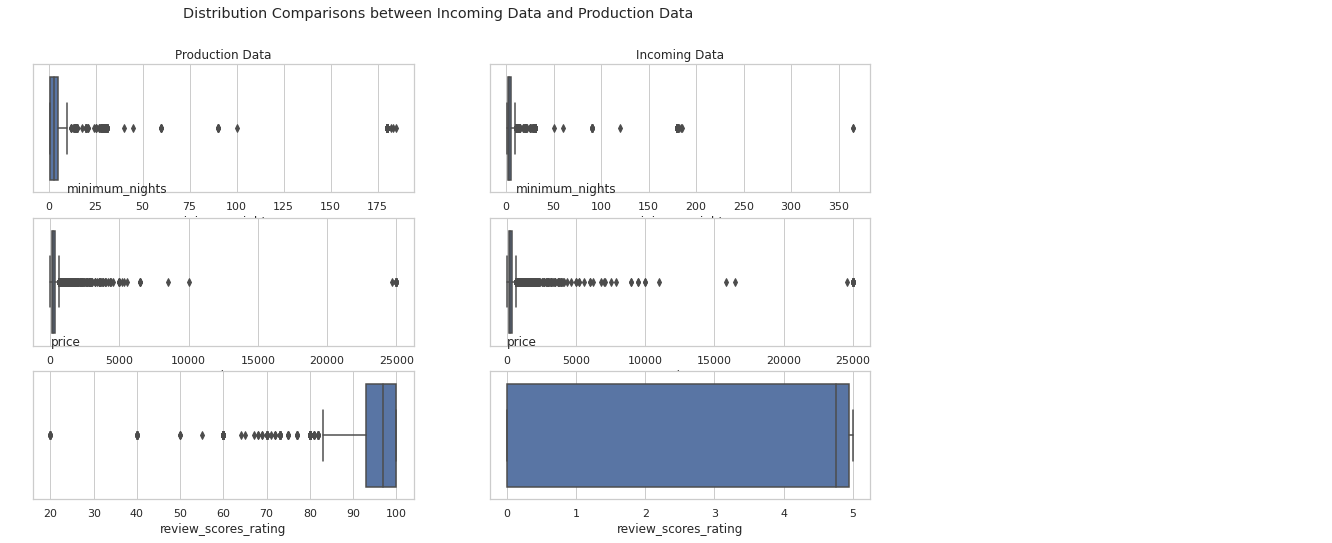

In [0]:
print(f"Let's look at the box plots of the features that exceed the stats_threshold_limit of {stats_threshold_limit}")
plot_boxplots(unique_feature_diff_array_month_1, current_prod_pdf_1, month_1_err_pdf)

In [0]:
print("\nCHECKING VARIANCES WITH LEVENE TEST.....")
check_diff_in_variances(current_prod_pdf_1, month_1_err_pdf, num_cols, p_threshold)

print("\nCHECKING KS TEST.....")
check_dist_ks_bonferroni_test(current_prod_pdf_1, month_1_err_pdf, num_cols, p_threshold)

CHECKING VARIANCES WITH LEVENE TEST.....
No features have significantly different variances compared to production data at p-value 0.05

CHECKING KS TEST.....
The Bonferroni-corrected alpha level is 0.0071. Any features with KS statistic below this alpha level have shifted significantly.
The feature(s) below have significantly different distributions compared to production data at Bonferroni-corrected alpha level of 0.0071, according to the KS test
 {'review_scores_rating': 0.0}

Using the KS test, only the `review_scores_rating` is shown to have shifted significantly.

**Categorical features**
* Check expected count for each level
* Check the mode

In [0]:
# Check that each categorical feature has the same mode and expected frequency distribution
check_categorical_diffs(current_prod_pdf_1, month_1_err_pdf, cat_cols, p_threshold)

The mode for neighbourhood_cleansed has changed from Primary Urban Center to North Shore Kauai.

Categorical varibles with different number of levels compared to the production data:
 ['neighbourhood_cleansed', 'property_type']

Chi-square test with p-value of 0.05:
	Categorical variables with significantly different expected count: {'host_is_superhost': 0.04369660890758696}

**`Action`: Resolve Data Issues**

After catching the data issues and working with the team in charge of upstream data processing, we resolve the issues with `review_scores_rating` and `neighbourhood_cleansed`. We add the fixed new month of data to our Gold Delta table and conduct training on the newly available data.

In [0]:
# Incoming Month 1 Data where upstream errors have been fixed
month_1_df = spark.read.format("delta").load(month_1_fixed_delta_path)

# Append new month of data to Gold Delta table to use for training
month_1_df.withColumn("month", F.lit("month_1")).write.format("delta").partitionBy("month").mode("append").save(gold_delta_path)

#### ii. Model Training

Retrain the same model, but this time we are able to use an extra month of data

In [0]:
# Set the month number - used for naming the MLflow run and logged as a parameter
month = 1

# Specify name of MLflow run
run_name = f"month_{month}"

# Define the parameters to pass in the RandomForestRegressor model
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}

# Define a dictionary of parameters that we would like to use during preprocessing
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}

# Trigger model training and logging to MLflow
month_1_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path,   
                                     model_params, 
                                     misc_params)

In [0]:
# Register model to MLflow Model Registry
month_1_run_id = month_1_run.info.run_id
month_1_model_version = mlflow.register_model(model_uri=f"runs:/{month_1_run_id}/model", name=registry_model_name)

# Transition model to Staging
month_1_model_version = transition_model(month_1_model_version, stage="Staging")
print(month_1_model_version)

Registered model 'airbnb_hawaii' already exists. Creating a new version of this model...
2021/06/12 16:46:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: airbnb_hawaii, version 2
Created version '2' of model 'airbnb_hawaii'.
<ModelVersion: creation_timestamp=1623516401035, current_stage='Staging', description='', last_updated_timestamp=1623516407442, name='airbnb_hawaii', run_id='d4a57458b4494b0abe57021404af9eec', run_link='', source='dbfs:/databricks/mlflow-tracking/2808846569707146/d4a57458b4494b0abe57021404af9eec/artifacts/model', status='READY', status_message='', tags={}, user_id='4470711271069202', version='2'>

#### iii. Model checks prior to model deployment

In [0]:
# Get the original MLflow run associated with the model registered under Staging
current_staging_run_1 = get_run_from_registered_model(registry_model_name, stage="Staging")

metric_to_check = "test_r2"
compare_model_perfs(current_staging_run_1, current_prod_run_1, min_model_r2_threshold, metric_to_check)

Staging run's test_r2: 0.113
Current production run's test_r2: 0.08
The current staging run exceeds the model improvement threshold of at least +0.1. You may proceed with transitioning the staging model to production now.

In [0]:
month_1_model_version = transition_model(month_1_model_version, stage="Production")
print(month_1_model_version)

<ModelVersion: creation_timestamp=1623516401035, current_stage='Production', description='', last_updated_timestamp=1623516407886, name='airbnb_hawaii', run_id='d4a57458b4494b0abe57021404af9eec', run_link='', source='dbfs:/databricks/mlflow-tracking/2808846569707146/d4a57458b4494b0abe57021404af9eec/artifacts/model', status='READY', status_message='', tags={}, user_id='4470711271069202', version='2'>

### Month 2 - New Data Arrives

We have had a model in production for 2 months now and have now obtained an additional month of data.

**Scenario 2:**
* The new month of data contains listing entries recorded during peak vacation season. As a result, the price for every listing has been increased.

**What are we simulating here?**
* Label drift
* Concept drift
  * The underlying relationship between the features and label has changed due to seasonality

#### i. Feature checks prior to model training

**All features**
* Null checks

**Numeric features**
* Summary statistic checks: mean, median, standard deviation, minimum, maximum
* Distribution checks

**Categorical features**
* Check expected count for each level
* Check the mode

In [0]:
# Incoming Month 2 Data - we have synthesised some distribution changes in our label which we would necessarily want to catch
month_2_df = spark.read.format("delta").load(month_2_delta_path)

# Compute summary statistics on new incoming data
month_2_pdf = month_2_df.toPandas()
summary_stats_month_2_pdf = create_summary_stats_pdf(month_2_pdf)

In [0]:
# Get the original MLflow run associated with the model registered under Production
current_prod_run_2 = get_run_from_registered_model(registry_model_name, stage="Production")

# Load in original versions of Delta table used at training time for current Production model
current_prod_pdf_2 = load_delta_table_from_run(current_prod_run_2).toPandas()

# Load summary statistics pandas DataFrame for data which the model currently in Production was trained and evaluated against
current_prod_stats_pdf_2 = load_summary_stats_pdf_from_run(current_prod_run_2, project_local_tmp_dir)

Loading Delta table from path: /Users/chengyin.eng@databricks.com/mlops2021/data/airbnb_hawaii_delta; version: 1
Summary stats artifact downloaded in: /dbfs/Users/chengyin.eng@databricks.com/mlops2021/tmp/summary_stats.csv

**All features**
* Null checks

In [0]:
print("\nCHECKING PROPORTION OF NULLS.....")
check_null_proportion(month_2_pdf, null_proportion_threshold=.5)

CHECKING PROPORTION OF NULLS.....

**Numeric features**
* Summary statistic checks: mean, median, standard deviation, minimum, maximum
* Distribution checks

In [0]:
unique_feature_diff_array_month_2 = check_diff_in_summary_stats(summary_stats_month_2_pdf, 
                                                                current_prod_stats_pdf_2, 
                                                                num_cols + [target_col], 
                                                                stats_threshold_limit, 
                                                                statistic_list)

unique_feature_diff_array_month_2

CHECKING accommodates.........
	The min accommodates in the new data is at least 50.0% higher than the min in the production data. Increased from 0.0 to 1.0.

CHECKING bedrooms.........

CHECKING beds.........

CHECKING minimum_nights.........

CHECKING number_of_reviews.........

CHECKING number_of_reviews_ltm.........

CHECKING review_scores_rating.........

CHECKING price.........
	The mean price in the new data is at least 50.0% higher than the mean in the production data. Increased from 387.95 to 774.34.
	The median price in the new data is at least 50.0% higher than the median in the production data. Increased from 202.0 to 402.16.
	The std price in the new data is at least 50.0% higher than the std in the production data. Increased from 1380.69 to 2870.57.
	The min price in the new data is at least 50.0% higher than the min in the production data. Increased from 0.0 to 22.38.
	The max price in the new data is at least 50.0% higher than the max in the production data. Increased from 25000.0 to 74994.63.
Out[73]: array(['accommodates', 'price'], dtype='<U12')

Let's look at the box plots of the features that exceed the stats_threshold_limit of 0.5

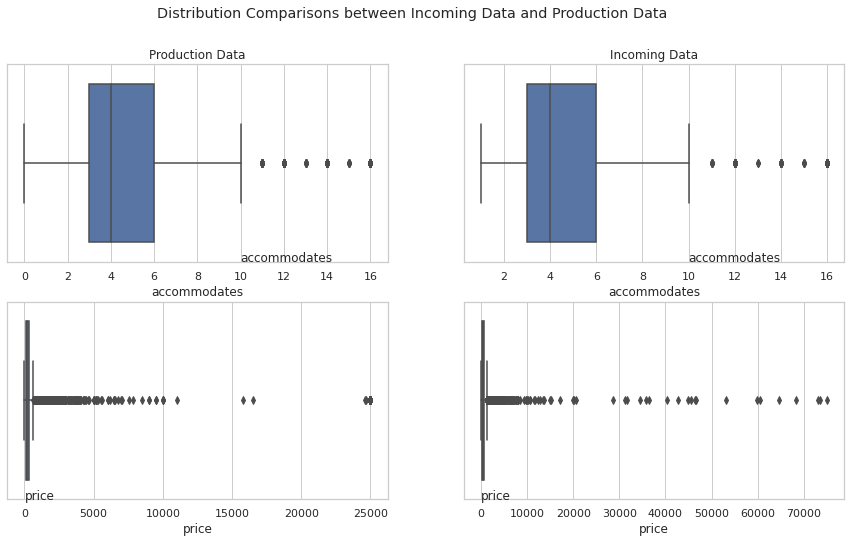

In [0]:
print(f"Let's look at the box plots of the features that exceed the stats_threshold_limit of {stats_threshold_limit}")
plot_boxplots(unique_feature_diff_array_month_2, current_prod_pdf_2, month_2_pdf)

In [0]:
print("\nCHECKING VARIANCES WITH LEVENE TEST.....")
check_diff_in_variances(current_prod_pdf_2, month_2_pdf, num_cols, p_threshold)

print("\nCHECKING KS TEST.....")
check_dist_ks_bonferroni_test(current_prod_pdf_2, month_2_pdf, num_cols + [target_col], p_threshold)

CHECKING VARIANCES WITH LEVENE TEST.....
No features have significantly different variances compared to production data at p-value 0.05

CHECKING KS TEST.....
The Bonferroni-corrected alpha level is 0.0063. Any features with KS statistic below this alpha level have shifted significantly.
The feature(s) below have significantly different distributions compared to production data at Bonferroni-corrected alpha level of 0.0063, according to the KS test
 {'price': 0.0}

**Categorical features**
* Check expected count for each level
* Check the mode

In [0]:
check_categorical_diffs(current_prod_pdf_2, month_2_pdf, cat_cols, p_threshold)

Categorical varibles with different number of levels compared to the production data:
 ['neighbourhood_cleansed', 'property_type']

Chi-square test with p-value of 0.05:
	Categorical variables with significantly different expected count: {'host_is_superhost': 0.0, 'room_type': 0.0}

**`Action`: Include new data with label drift in training**

We observe that our label has drifted, and after analysis observe that this most recent month of data was captured during peak vacation season where Airbnb hosts have increased their listing prices. As such, we will retrain our model and include this recent month of data during training.

In [0]:
# Append the new month of data (where listings are most expensive across the board)
month_2_df.withColumn("month", F.lit("month_2")).write.format("delta").partitionBy("month").mode("append").save(gold_delta_path)

#### ii. Model Training

Retrain the same model from previous months, including the additional month of data where the label has drifted.

In [0]:
# Set the month number - used for naming the MLflow run and logged as a parameter
month = 2

# Specify name of MLflow run
run_name = f"month_{month}"

# Define the parameters to pass in the RandomForestRegressor model
model_params = {"n_estimators": 500,
                "max_depth": 5,
                "max_features": "log2"}

# Define a dictionary of parameters that we would like to use during preprocessing
misc_params = {"month": month,
               "target_col": target_col,
               "cat_cols": cat_cols,
               "num_cols": num_cols}

# Trigger model training and logging to MLflow
month_2_run = train_sklearn_rf_model(run_name, 
                                     gold_delta_path, 
                                     model_params, 
                                     misc_params)

In [0]:
# Register model to MLflow Model Registry
month_2_run_id = month_2_run.info.run_id
month_2_model_version = mlflow.register_model(model_uri=f"runs:/{month_2_run_id}/model", name=registry_model_name)

# Transition model to Staging
month_2_model_version = transition_model(month_2_model_version, stage="Staging")
print(month_2_model_version)

Registered model 'airbnb_hawaii' already exists. Creating a new version of this model...
2021/06/12 16:47:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: airbnb_hawaii, version 3
Created version '3' of model 'airbnb_hawaii'.
<ModelVersion: creation_timestamp=1623516425398, current_stage='Staging', description='', last_updated_timestamp=1623516431772, name='airbnb_hawaii', run_id='1e761ef62fea4fa3be30271db417cb60', run_link='', source='dbfs:/databricks/mlflow-tracking/2808846569707146/1e761ef62fea4fa3be30271db417cb60/artifacts/model', status='READY', status_message='', tags={}, user_id='4470711271069202', version='3'>

#### iii. Model checks prior to model deployment

In [0]:
# Get the MLflow run associated with the model currently registered in Staging
current_staging_run_2 = get_run_from_registered_model(registry_model_name, stage="Staging")

In [0]:
metric_to_check = "test_r2"
compare_model_perfs(current_staging_run_2, current_prod_run_2, min_model_r2_threshold, metric_to_check)

Staging run's test_r2: 0.043
Current production run's test_r2: 0.113
ALERT: The current staging run underperforms by -61.94% when compared to the production model. Do not transition the staging model to production.

In this case we note that the new candidate model in Staging performs notably worse than the current model in Production. We know from our checks prior to training that the label has drifted, and that this was due to new listing prices being recorded during vacation season. At this point we would want to prevent a migration of the new candidate model directly to Production and instead investigate if there is any way we can improve model performance. This could involve tuning the hyperparameters of our model, or additionally investigating the inclusion of additional features such as "month of the year" which could allow us to capture temporal impacts to listing prices.

In [0]:
# month_2_model_version = transition_model(month_2_model_version, stage="Production")
# print(month_2_model_version)